# Tutorial 4 - Data Imputation

**Course:** SYSC 4415 - Introduction to Machine Learning

**Semester:** Fall 2021

**Adapted by:** [Kevin Dick](https://kevindick.ai/)

**Adapted From:** [Daniel Newman](https://github.com/dtnewman)'s [Notebook](https://nbviewer.jupyter.org/github/dtnewman/gradient_descent/blob/master/stochastic_gradient_descent.ipynb)

---

## Illustration of the Effect of Missing Data during Training and Testing

In this notebook, we will simulate the process of **filling in missing data with imiputed values**. 

We will compare the performance of a classifeir trained/tested on the dataets containing imputed values versus one where those rows are simply removed.

The general workflow is as follows:
1. Load the [Iris Dataset](https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/orig-iris-data.csv)
2. Split data into train/test sets (50/50)
3. For i = 10:10:70%
    * **Impute Condition**
      - **Remove i%** of the training data from one feature
      - **Impute missing data** using **mean** of all data from that class
      - Train classifier
      - Test classifier
      - **Report score** along with i
    * **Removal Condition**
      - Remove training rows by replaving with NaN values,
      - Train Classifier
      - Test Classifier
      - **Report score** along with i


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Load the dataset
url = 'https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/F2019/orig-iris-data.csv'
iris_data = pd.read_csv(url)
# Note that iris = seaborn.load_dataset("iris") would also work (with diff column names)

# Quickly visualize first few rows
iris_data.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


To simplify the experiment, we will only consider a single feature: `sepal_width_cm`

In [ ]:
# Drop all features except petal_width_cm
iris_data.drop(['sepal_length_cm', 'petal_length_cm', 'petal_width_cm'], axis=1, inplace=True)
#
# Describe the data (gives range of each feature, etc)
iris_data.describe()

,sepal_width_cm
count,150.000000
mean,3.054000
std,0.433594
min,2.000000
25%,2.800000
50%,3.000000
75%,3.300000
max,4.400000


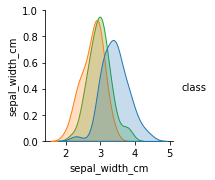

In [ ]:
# Plot the features, in pairs
sb.pairplot(iris_data.dropna(), hue='class'); # Dropping NA values, but shouldn't be any yet...

### Avoid Data Leakage: Split the Dataset into Train and Test 

**Critical:** we MUST split the dataset before we impute the values!

**[Data Leakage](https://www.kaggle.com/alexisbcook/data-leakage)** occurs when information about the **test samples** are somehow **encoded** within the **training dataset**. This results in a biased, overfit, and non-generalizable method and inflates the performance.

In this case, the values from the test dataset should not be used for imputation of missing values in the training dataset.

In [ ]:
# Split the data (doing this in Pandas rather than using sklearn)
iris_data_copy = iris_data.copy()
train_set = iris_data_copy.sample(frac=0.5, random_state=0)
test_set = iris_data_copy.drop(train_set.index)

### Run the Experiment

In [ ]:
# Vary the amount of missing feature values from 10% to 90%
for i in np.linspace(0.1, 0.9, num=9):
  # Randomly select some rows based on the current fraction
  missingRows = train_set.sample(frac=i, random_state=1)
  train_set_copy = train_set.copy()

  # Replace those selected rows with NaN --> 'simulated missing data'
  train_set_copy.loc[missingRows.index, 'sepal_width_cm'] = np.NaN; # Replace missing rows with NaN for sepal_width_cm feature

  # Remove the missing rows prior to computing the mean of the feature:
  train_set_noNA = train_set_copy.dropna(inplace=False)

  # Compute the average petal width, for each class (compute from non-NA rows)
  average_petal_width1 = train_set_noNA.loc[train_set_noNA['class'] == 'Iris-setosa', 'sepal_width_cm'].mean()
  average_petal_width2 = train_set_noNA.loc[train_set_noNA['class'] == 'Iris-versicolor', 'sepal_width_cm'].mean()
  average_petal_width3 = train_set_noNA.loc[train_set_noNA['class'] == 'Iris-virginica', 'sepal_width_cm'].mean()
  
  # Replace missing values with the mean value for that class
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-setosa') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_petal_width1
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-versicolor') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_petal_width2
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-virginica') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_petal_width3

  # Extract the data/classes from pandas into nparrays for the classifier:
  features = train_set_copy['sepal_width_cm'].values.reshape(-1,1)
  labels = train_set_copy['class'].values.reshape(-1,1)

  # CONDITION 1: With Imputation
  # Train a DT classifier with imputation
  decision_tree_classifier = DecisionTreeClassifier()
  decision_tree_classifier.fit(features, labels)

  # Test the DT classifier with imputation
  test_features = test_set['sepal_width_cm'].values.reshape(-1,1)
  test_labels = test_set['class'].values.reshape(-1,1)
  score = decision_tree_classifier.score(test_features, test_labels)

  # Train a DT classifier without imputation
  features_noNA = train_set_noNA['sepal_width_cm'].values.reshape(-1,1)
  labels_noNA = train_set_noNA['class'].values.reshape(-1,1)
  decision_tree_classifier2 = DecisionTreeClassifier()
  decision_tree_classifier2.fit(features_noNA, labels_noNA)

  # Test the DT classifier without imputation (NaN rows removed)
  score_noNA = decision_tree_classifier2.score(test_features, test_labels)

  # Print the score:
  print('For {:.0f}% missing data:\tAcc. Imputed: {:.2f}\tAcc. Dropped: {:.2f}\t diff: {:.2f}'.format(i*100, score, score_noNA, score-score_noNA))

For 10% missing data:	Acc. Imputed: 0.49	Acc. Dropped: 0.49	 diff: 0.00
For 20% missing data:	Acc. Imputed: 0.45	Acc. Dropped: 0.45	 diff: 0.00
For 30% missing data:	Acc. Imputed: 0.47	Acc. Dropped: 0.47	 diff: 0.00
For 40% missing data:	Acc. Imputed: 0.49	Acc. Dropped: 0.49	 diff: 0.00
For 50% missing data:	Acc. Imputed: 0.55	Acc. Dropped: 0.53	 diff: 0.01
For 60% missing data:	Acc. Imputed: 0.60	Acc. Dropped: 0.55	 diff: 0.05
For 70% missing data:	Acc. Imputed: 0.49	Acc. Dropped: 0.49	 diff: 0.00
For 80% missing data:	Acc. Imputed: 0.53	Acc. Dropped: 0.53	 diff: 0.00
For 90% missing data:	Acc. Imputed: 0.52	Acc. Dropped: 0.52	 diff: 0.00


### Discussion

**Questions:**
1.  What if feature data were missing from the test data? 
2.  How would you impute the missing feature values? 
3.  Would it have more or less of an effect than missing data during training?

## Take Away Messages
* Imputation is a method to fill in missnig values.
* **Data Leakage** occurs when information about the **test samples** are somehow **encoded** within the **training dataset** resulting in possible overfitting and inflated model performance.
* Impuation vs. dropping samples generally leads to higher performance.
* Imputation in the test set should only be done if you have domain knowledge (e.g. an expert) or you know that you will obtain that value during deployment.

---

### (Optional) Open-Ended/Applied Homework
* Implement **your own/other** data imputation methods.
* **Compare performance** with mean-based imputation
* Does one perform **statistically significantly** better than simply dropping samples?
* What happens when you have **multiple features**?
* Can you impute the value of **one missing feature using other features**?
---

$\blacksquare$
